# Setting-up environment

In [1]:
!cp -r ../input/updated-code-3-7/* /kaggle/working/

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 57.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 38.2 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=447716 sha256=82007790ed47a5a1b4a9622a84ff1a0d9933f80d171ea0ee512c2a18cbf74bde
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
  Created wheel for jupyter-contrib-nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428781 sha256=369301c9c9cd0b103c0c6d60fa6313b8a2853a53d8da1211abf6a208159551cc
  Stored in directory: /root/.cache/pip/wheels/ea/cc/7d/99ef15

In [2]:
!pip install lightfm tqdm optuna ipykernel matplotlib implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.5 MB/s eta 0:00:00:00:010:01
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=447716 sha256=510c6a3012326cb271f619dcc3cf5f49863e23f410991976bbbd95d327292f71
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [3]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disable it with 

# Imports

In [4]:
import time
import optuna
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy.sparse import vstack, csr_matrix
from scipy.stats import loguniform
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.BaseMatrixFactorizationRecommender import BaseMatrixFactorizationRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

#---- CF
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

#---- Matrix Factorization
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#---- CF w/ ML
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender, MultiThreadSLIM_SLIMElasticNetRecommender
from implicit.als import AlternatingLeastSquares

#---- Others
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.Recommender_utils import check_matrix

In [6]:
seed = 69
np.random.seed(seed)

# Data Import and Preprocessing

In [7]:
# Import training data
URM_path = "../input/data-books/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                header=0,
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["user_id", "item_id", "interaction"]

In [8]:
# Import target users
target_path = "../input/data-books/data_target_users_test.csv"
target_dataframe= pd.read_csv(filepath_or_buffer=target_path,
                                header=0,
                                dtype={0:int},
                                engine='python')
target_dataframe.columns = ["user_id"]
target_dataframe

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
10877,13020
10878,13021
10879,13022
10880,13023


In [9]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()

    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()

    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)

    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})

    ratings = pd.merge(left=ratings,
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")

    ratings = pd.merge(left=ratings,
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")

    return ratings

In [10]:
# Call preprocess data function
ratings = preprocess_data(URM_all_dataframe)

12638 1 13024
22222 1 22347


## Conversion to Sparse Matrix

In [11]:
URM = sps.coo_matrix((ratings.interaction.values, (ratings.mapped_user_id.values, ratings.mapped_item_id.values)))

## Data Splits

In [12]:
urm_train, urm_validation = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
#urm_train, urm_validation = split_train_in_two_percentage_global_sample(urm_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
#evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2127 (16.8%) Users that have less than 1 test interactions


# **Custom Models**

In [13]:
class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2


    def fit(self, alpha=0.5):
        self.alpha = alpha

    def _compute_item_score(self, user_id_array, items_to_compute):

        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [14]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights

In [15]:
class LightFMCFRecommender(BaseRecommender):
    """LightFMCFRecommender"""

    RECOMMENDER_NAME = "LightFMCFRecommender"

    def __init__(self, URM_train):
        super(LightFMCFRecommender, self).__init__(URM_train)
    
    
    def fit(self, epochs = 300, user_alpha=1e-6, item_alpha = 1e-6, n_factors = 10, n_threads = 4, max_sampled=3, loss='warp', learning_schedule='adagrad'):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss=loss,
                                     user_alpha=user_alpha,
                                     item_alpha=item_alpha,
                                     no_components=n_factors,
                                     max_sampled=max_sampled,
                                     learning_schedule=learning_schedule)

        self.lightFM_model = self.lightFM_model.fit(self.URM_train, 
                                       epochs=epochs,
                                       num_threads=n_threads,
                                       verbose=True)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        items_to_compute = np.arange(self.n_items)
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute)

        return item_scores

In [16]:
class GeneralizedLinearHybridRecommender(BaseRecommender):
    """
    This recommender merges N recommendes by weighting their ratings
    """

    RECOMMENDER_NAME = "GeneralizedLinearHybridRecommender"

    def __init__(self, URM_train, recommenders: list, verbose=True):
        self.RECOMMENDER_NAME = ''
        for recommender in recommenders:
            self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + recommender.RECOMMENDER_NAME[:-11]
        self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + 'HybridRecommender'

        super(GeneralizedLinearHybridRecommender, self).__init__(URM_train, verbose=verbose)

        self.recommenders = recommenders

    def fit(self, alphas=None):
        self.alphas = alphas

    def save_model(self, folder_path, file_name=None):
        pass

    def _compute_item_score(self, user_id_array, items_to_compute=None):
        result = self.alphas[0]*self.recommenders[0]._compute_item_score(user_id_array,items_to_compute)
        for index in range(1,len(self.alphas)):
            result = result + self.alphas[index]*self.recommenders[index]._compute_item_score(user_id_array,items_to_compute)
        return result

In [17]:
class FastIALSRecommender(BaseMatrixFactorizationRecommender):
    RECOMMENDER_NAME = "FastIALSRecommender"

    AVAILABLE_CONFIDENCE_SCALING = ["linear", "log"]
    
    def __init__(self, URM_train, verbose=True):
        super().__init__(URM_train, verbose=verbose)
        
    def fit(self,
            factors=20,
            regularization=1e-3,
            iterations=100,
            calculate_training_loss=False,
            num_threads=0,
            confidence_scaling='linear',
            alpha=1.0,
            epsilon=0,
            #---- Do not change
            use_native=True,
            use_cg=True,
            use_gpu=True):
        if confidence_scaling not in self.AVAILABLE_CONFIDENCE_SCALING:
           raise ValueError("Value for 'confidence_scaling' not recognized. Acceptable values are {}, provided was '{}'".format(self.AVAILABLE_CONFIDENCE_SCALING, confidence_scaling))

        self.alpha = alpha
        self.epsilon = epsilon
        self.num_factors = factors
        self.reg = regularization
        
        self.USER_factors = self._init_factors(self.n_users, False)  # don't need values, will compute them
        self.ITEM_factors = self._init_factors(self.n_items)
        
        self.recommender = AlternatingLeastSquares(factors=factors, regularization=regularization,
                                                        use_native=use_native, use_cg=use_cg, use_gpu=use_gpu,
                                                        iterations=iterations,
                                                        calculate_training_loss=calculate_training_loss,
                                                        num_threads=num_threads)
        
        self._build_confidence_matrix(confidence_scaling)
        self.recommender.fit(self.C, show_progress=self.verbose)
        
        self.USER_factors = self.recommender.user_factors.to_numpy()
        self.ITEM_factors = self.recommender.item_factors.to_numpy()
        
    
    def _linear_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha*C.data

        return C

    def _log_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha * np.log(1.0 + C.data / self.epsilon)

        return C
    
    def _build_confidence_matrix(self, confidence_scaling):

        if confidence_scaling == 'linear':
            self.C = self._linear_scaling_confidence()
        else:
            self.C = self._log_scaling_confidence()

        self.C_csc= check_matrix(self.C.copy(), format="csc", dtype = np.float32)
    
    def _init_factors(self, num_factors, assign_values=True):

        if assign_values:
            return self.num_factors**-0.5*np.random.random_sample((num_factors, self.num_factors))

        else:
            return np.empty((num_factors, self.num_factors))

# **Best Model Params**

In [18]:
ItemKNN_params = {
 'topK': 21,
 'shrink': 1462,
 'similarity': 'tanimoto',
 'normalize': False,
 'feature_weighting': 'BM25'
}

In [19]:
RP3Beta_params = {
 'alpha': 0.3302958327908062,
 'beta': 0.14271386569051958,
 'topK': 29,
 'normalize_similarity': True
}

In [20]:
alpha_itemknn_rp3beta=0.7381515719042592

In [21]:
UserKNN_params = {
 'topK': 387,
 'shrink': 1,
 'similarity': 'cosine',
 'normalize': True,
 'feature_weighting': 'TF-IDF'
}

In [22]:
LightFM_params = {
                  'n_factors': 482,
                  'max_sampled': 5,
                  'user_alpha': 0.00023989649900734266,
                  'item_alpha': 9.740651135253414e-05
                 }

In [23]:
SLIM_params = {
 'l1_ratio': 0.04324773367371399,
 'alpha': 0.001220701931267383,
 'topK': 971
}

In [24]:
NMF_params = {
    'l1_ratio': 0.005734775635120469,
    'num_factors': 134,
    'beta_loss': 'frobenius',
    'init_type': 'nndsvda',
    'solver': 'multiplicative_update'
}

In [25]:
IALS_params = {
'factors': 216, 
'confidence_scaling': 'linear', 
'alpha': 2.971319492415353, 
'epsilon': 0.27505837539726546, 
'regularization': 0.0062196937352773235
}

## Pairwise tuning

In [26]:
itemKNNCF = ItemKNNCFRecommender(urm_train)
itemKNNCF.fit(**ItemKNN_params)

ItemKNNCFRecommender: URM Detected 240 ( 1.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 123 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 5126.25 column/sec. Elapsed time 4.33 sec


In [27]:
rp3beta = RP3betaRecommender(urm_train)
rp3beta.fit(**RP3Beta_params)

RP3betaRecommender: URM Detected 240 ( 1.9%) users with no interactions.
RP3betaRecommender: URM Detected 123 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 1661.53 column/sec. Elapsed time 13.37 sec


In [ ]:
#slim = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train)
#slim.fit(**SLIM_params, workers = int(cpu_count()))

In [28]:
ials = FastIALSRecommender(urm_train)
ials.fit(**IALS_params)

FastIALSRecommender: URM Detected 240 ( 1.9%) users with no interactions.
FastIALSRecommender: URM Detected 123 ( 0.6%) items with no interactions.


  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
result_df, _ = evaluator_validation.evaluateRecommender(ials)
result_df

EvaluatorHoldout: Processed 10459 (100.0%) in 9.40 sec. Users per second: 1113


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.072454,0.131769,0.113981,0.035454,0.064495,0.220529,0.118674,0.088593,0.448513,0.277391,...,0.827583,0.371182,0.827583,0.027418,9.677444,0.998579,0.078688,0.74557,1.494427,0.279127


### Plotting Recommendations scores

In [29]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [31]:
user_id = 1

rp3beta_scores = rp3beta._compute_item_score(user_id).flatten()
#slim_scores = slim._compute_item_score(user_id).flatten()
itemknn_scores = itemKNNCF._compute_item_score(user_id).flatten()  
ials_scores = ials._compute_item_score(user_id).flatten()

In [441]:
scores = ials_scores.reshape(-1,1)

# Score Rescaling

In [34]:
import warnings
warnings.filterwarnings("ignore")

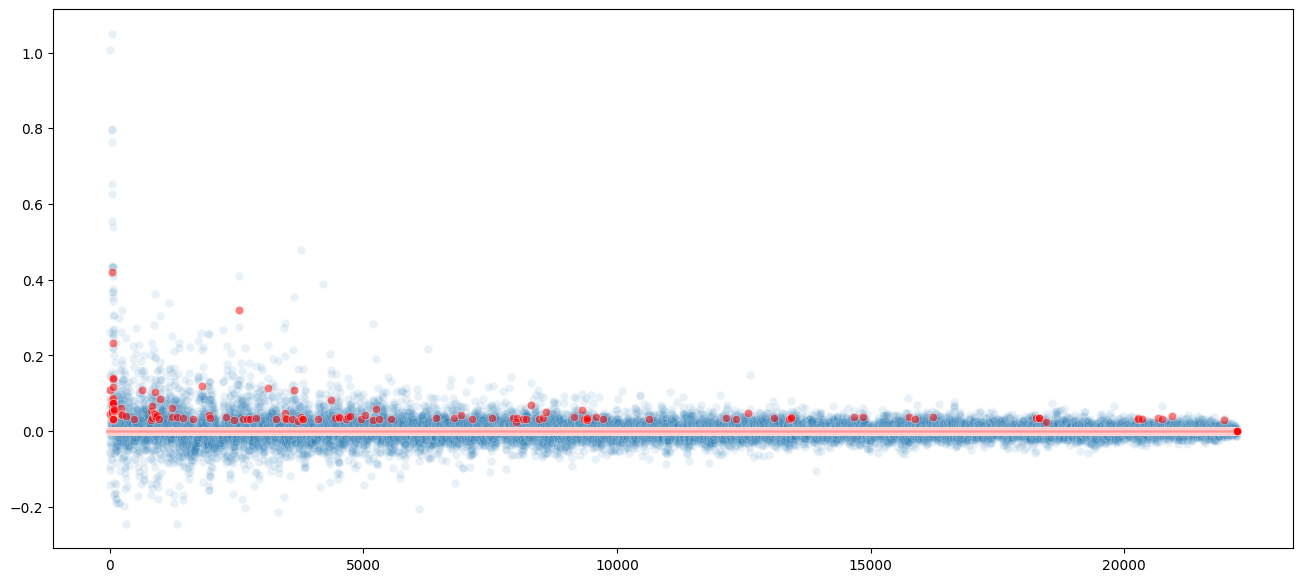

In [35]:
_ = plt.figure(figsize=(16,7))

ax = sns.scatterplot(data=ials_scores, alpha=0.1)
ax = sns.scatterplot(data=rp3beta_scores, alpha=0.5, color = "red")


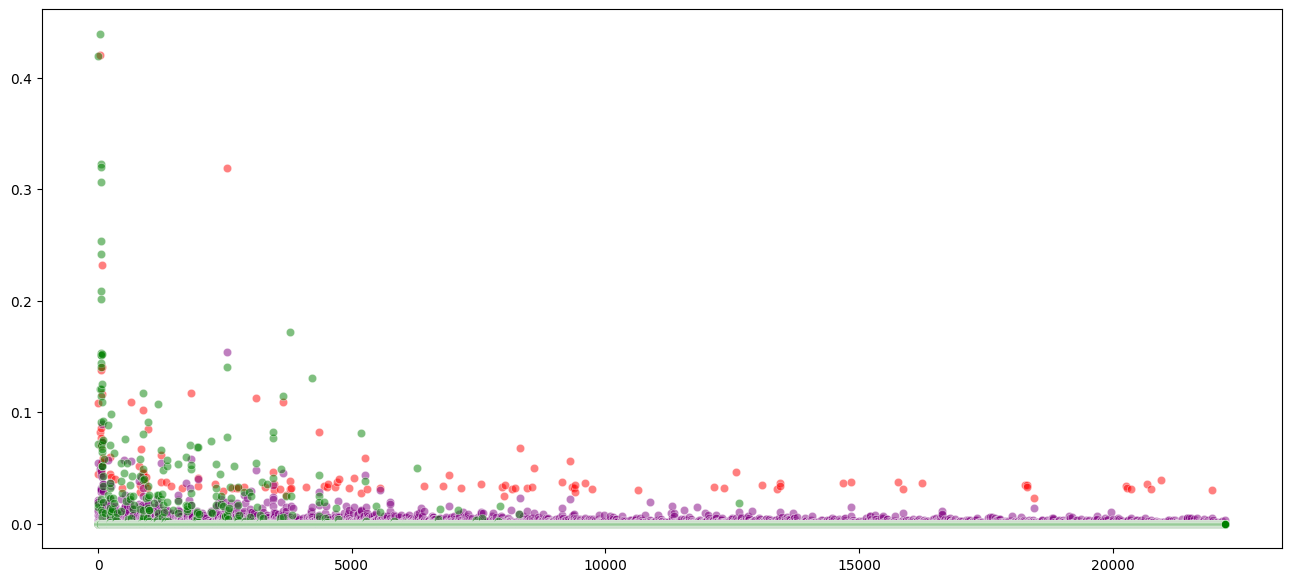

In [70]:
#print(scores)
min_ = ials_scores.min()
max_ = ials_scores.max()

smoothed_data = ials_scores.copy()

smoothed_data[smoothed_data < 0] = 0

kernel_size = 4
sigma = 1

# Creazione del kernel esponenziale
#kernel_size è la dimensione del kernel, e sigma controlla la larghezza del kernel esponenziale.
kernel = np.exp(-np.linspace(-(kernel_size-1)/2, (kernel_size-1)/2, kernel_size)**2 / (2 * sigma**2))

# Applicazione della convoluzione
#smoothed_data = np.convolve(smoothed_data, kernel, mode='same') / np.sum(kernel)

threshold = np.percentile(smoothed_data, 99)
smoothed_data[smoothed_data <= threshold] = 0.0

# Get the unique elements in the array
unique_elements = np.unique(smoothed_data)

# Use numpy.partition to find the second smallest unique element
# We use index 1 since we are interested in the second smallest element
partitioned_array = np.partition(unique_elements, 1)

# The second smallest element is now at index 1
min_score = partitioned_array[1]
max_score = smoothed_data.max()

smoothed_data = (smoothed_data - min_score)/(max_score-min_score + 1.2)

smoothed_data[smoothed_data < 0] = 0

_ = plt.figure(figsize=(16,7))



#ax = sns.scatterplot(data=ials_scores, alpha=0.5, color = 'orange')
ax = sns.scatterplot(data=rp3beta_scores, alpha=0.5, color = "red")
ax = sns.scatterplot(data=itemknn_scores, alpha = 0.5, color = "purple")
ax = sns.scatterplot(data=smoothed_data, alpha=0.5, color = 'green')
